# Question 6: RNN - LSTM - NLP 
- Use Clothing, Shoes and Jewelry dataset (file Clothing_Shoes_and_Jewelry_5.json in reviews_Clothing_Shoes_and_Jewelry_5.json.gz) to build a model to predict customer sentiment  based on their review 
- Read more information here: http://jmcauley.ucsd.edu/data/amazon/

# 0. Mount drive & import packages

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question6_RNN_LSTM_NLP'

/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question6_RNN_LSTM_NLP


In [3]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

# 1. Load data

In [4]:
data = pd.read_json("reviews_Clothing_Shoes_and_Jewelry_5.json.gz",lines=True)

In [5]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [6]:
data.shape

(278677, 9)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      278677 non-null  object
 1   asin            278677 non-null  object
 2   reviewerName    278225 non-null  object
 3   helpful         278677 non-null  object
 4   reviewText      278677 non-null  object
 5   overall         278677 non-null  int64 
 6   summary         278677 non-null  object
 7   unixReviewTime  278677 non-null  int64 
 8   reviewTime      278677 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [8]:
df = data[['reviewText','overall']]
df.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


In [9]:
df.info()         

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewText  278677 non-null  object
 1   overall     278677 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [10]:
df.duplicated().sum()

108

In [11]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [12]:
df.info()       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278569 entries, 0 to 278568
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewText  278569 non-null  object
 1   overall     278569 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


### Nhận xét:
- Không có giá trị null
- Kiểu dữ liệu đúng
- 108 dong duplicate  => dropp

In [13]:
df['WORDS'] = df['reviewText'].map(lambda x: len(x.split()))
df.head()

,reviewText,overall,WORDS
0,This is a great tutu and at a really great pri...,5,35
1,I bought this for my 4 yr old daughter for dan...,5,61
2,What can I say... my daughters have it in oran...,5,62
3,"We bought several tutus at once, and they are ...",5,76
4,Thank you Halo Heaven great product for Little...,5,80


In [14]:
df['WORDS'].describe()

count    278569.000000
mean         59.974480
std          61.291106
min           0.000000
25%          26.000000
50%          41.000000
75%          70.000000
max        3882.000000
Name: WORDS, dtype: float64

In [15]:
len(df['WORDS'][df['WORDS']==0])

5

In [16]:
numpy.percentile(df.WORDS,90)

118.0

In [17]:
df.overall.unique()

array([5, 4, 3, 1, 2])

In [18]:
# nhóm đánh giá thành 3 class (Like-2: 4&5 stars, Neutral-1: 3 stars, Dislike-0: 1&2 stars)
df.overall = df.overall.apply(lambda x: 2 if (x>3) else (1 if x==3 else 0))

In [19]:
df.overall.value_counts()

2    221495
1     30421
0     26653
Name: overall, dtype: int64

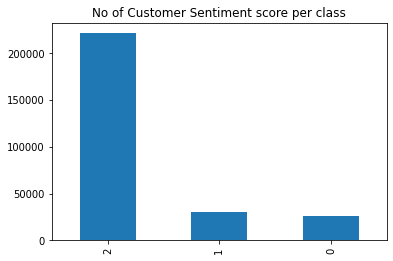

In [20]:
count = df.overall.value_counts()
count.plot(kind='bar')
plt.title('No of Customer Sentiment score per class')
plt.show()

### Nhận xét:      
- Range của số lượng từ trong review của khách hàng khá lớn (max 3882 từ, min 0)
- có 24 khách hàng đánh giá nhưng ko viết review
- dữ liệu không cân bằng 

In [21]:
# Split input & output
X = df.reviewText
Y = df.overall

In [22]:
# # Oversampling
# from imblearn.over_sampling import SMOTE
# sm = SMOTE()
# X_sm, Y_sm = sm.fit_resample(X,Y)

In [23]:
X.shape, Y.shape

((278569,), (278569,))

In [24]:
X.head()

0    This is a great tutu and at a really great pri...
1    I bought this for my 4 yr old daughter for dan...
2    What can I say... my daughters have it in oran...
3    We bought several tutus at once, and they are ...
4    Thank you Halo Heaven great product for Little...
Name: reviewText, dtype: object

In [25]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: overall, dtype: int64

In [26]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# ohe.fit(Y)
# Y = ohe.transform(Y)
# Y = pd.get_dummies(Y)
Y = to_categorical(Y, 3, dtype ="uint8")
Y = pd.DataFrame(Y)

In [27]:
Y.head()

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# 2. Process the data

In [29]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 
# text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [30]:
print(sequences[:2])

[[1, 29, 167, 13, 713, 5, 7, 2, 22, 1, 50, 1, 18, 33, 311, 2, 38, 339, 2, 867, 4, 402, 499, 1, 3, 2, 61, 23, 81, 365, 1, 26, 9, 52, 38, 14, 48, 51, 2, 52], [76, 2, 22, 35, 113, 256]]


In [31]:
# sequence_matrix[:2]

# 3. Build RNN Network

### 3.1 Model 1

In [32]:
model = Sequential()
model.add(Embedding(max_words,50))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 96,851
Trainable params: 96,851
Non-trainable params: 0
_________________________________________________________________


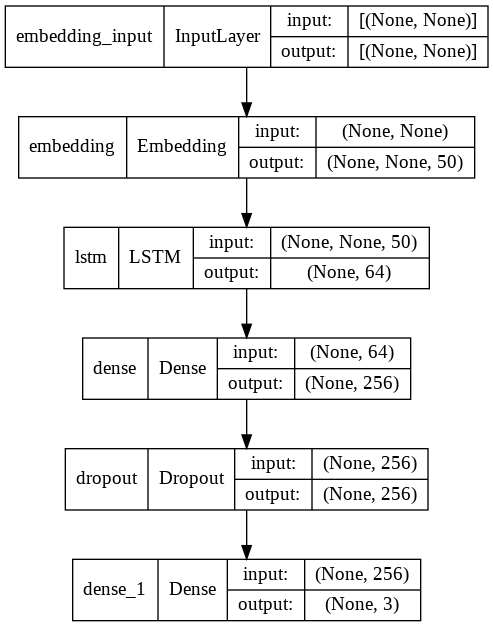

In [34]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='customer_sentiment_model.png', show_shapes=True)
Image(filename='customer_sentiment_model.png')

In [35]:
history = model.fit(sequence_matrix, y_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1219/1219 [==============================] - 19s 11ms/step - loss: 0.4914 - accuracy: 0.8141 - val_loss: 0.4512 - val_accuracy: 0.8223
Epoch 2/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.4316 - accuracy: 0.8312 - val_loss: 0.4163 - val_accuracy: 0.8369
Epoch 3/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.3988 - accuracy: 0.8426 - val_loss: 0.3976 - val_accuracy: 0.8439
Epoch 4/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.3828 - accuracy: 0.8481 - val_loss: 0.3834 - val_accuracy: 0.8479
Epoch 5/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.3730 - accuracy: 0.8523 - val_loss: 0.3861 - val_accuracy: 0.8496
Epoch 6/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.3667 - accuracy: 0.8546 - val_loss: 0.3768 - val_accuracy: 0.8465
Epoch 7/50
1219/1219 [==============================] - 13s 11ms/step - loss: 0.3603 - accuracy: 0.8566 - val_loss: 0.3750 -

In [36]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
12,0.330381,0.868620,0.373201,0.852000
13,0.326145,0.868934,0.380632,0.852846
14,0.322046,0.870960,0.372088,0.854410
15,0.316972,0.872242,0.384262,0.855385
16,0.312727,0.874005,0.389417,0.854051


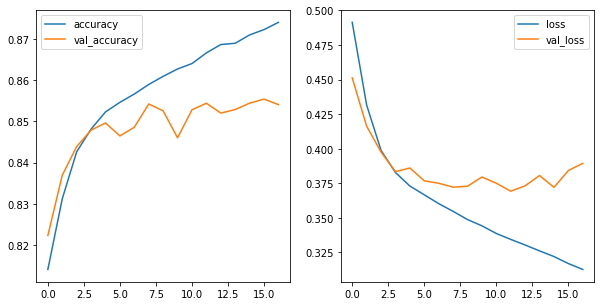

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.accuracy, label='accuracy')
plt.plot(history_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_df.loss, label='loss')
plt.plot(history_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [38]:
# test
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)

In [39]:
accr = model.evaluate(test_sequence_matrix, y_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

2612/2612 [==============================] - 11s 4ms/step - loss: 0.3851 - accuracy: 0.8552
Test set
 -Loss: 0.385
 -Accuracy: 0.855


In [40]:
# Save the result
model.save('customer_sentiment1.h5')

### 3.2 Model2

In [125]:
max_words = 5000
max_len = 120
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 

In [126]:
model2 = Sequential()
model2.add(Embedding(max_words,50))
model2.add(LSTM(64))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [127]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 50)          250000    
                                                                 
 lstm_10 (LSTM)              (None, 64)                29440     
                                                                 
 dense_23 (Dense)            (None, 256)               16640     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 3)                 771       
                                                                 
Total params: 296,851
Trainable params: 296,851
Non-trainable params: 0
_________________________________________________________________


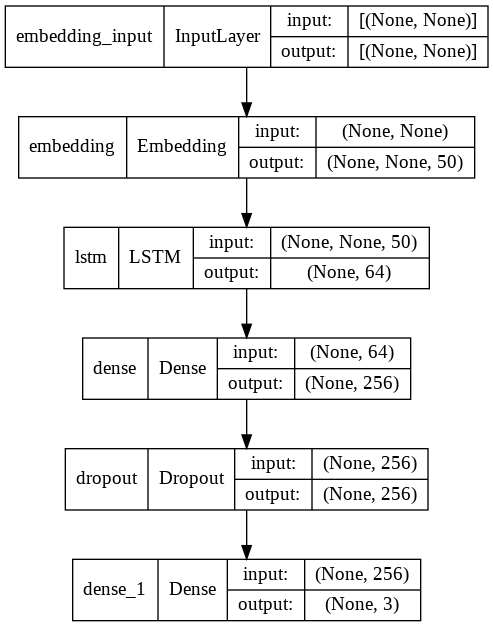

In [128]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='customer_sentiment_model2.png', show_shapes=True)
Image(filename='customer_sentiment_model2.png')

In [136]:
history2 = model2.fit(sequence_matrix, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_split=0.3,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.3158 - accuracy: 0.8753 - val_loss: 0.4261 - val_accuracy: 0.8439
Epoch 2/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.3185 - accuracy: 0.8747 - val_loss: 0.4262 - val_accuracy: 0.8337
Epoch 3/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.3151 - accuracy: 0.8757 - val_loss: 0.4167 - val_accuracy: 0.8472
Epoch 4/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.3119 - accuracy: 0.8777 - val_loss: 0.4181 - val_accuracy: 0.8494
Epoch 5/50
2133/2133 [==============================] - 20s 9ms/step - loss: 0.3088 - accuracy: 0.8788 - val_loss: 0.4047 - val_accuracy: 0.8471
Epoch 6/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.3042 - accuracy: 0.8812 - val_loss: 0.4175 - val_accuracy: 0.8444
Epoch 7/50
2133/2133 [==============================] - 19s 9ms/step - loss: 0.2991 - accuracy: 0.8833 - val_loss: 0.4295 - val_ac

In [137]:
history2_df = pd.DataFrame(history2.history)
history2_df.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.304217,0.881200,0.417478,0.844376
6,0.299102,0.883346,0.429465,0.845179
7,0.293587,0.886562,0.428577,0.848017
8,0.289617,0.887310,0.433553,0.835829
9,0.283781,0.890592,0.442094,0.829795


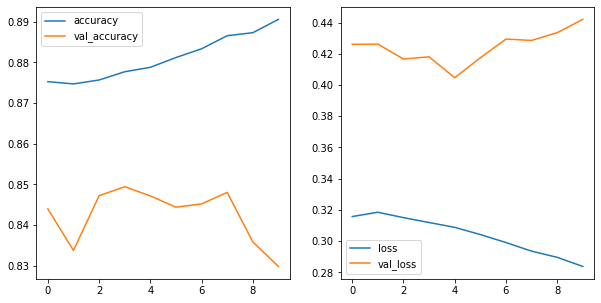

In [139]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2_df.accuracy, label='accuracy')
plt.plot(history2_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history2_df.loss, label='loss')
plt.plot(history2_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [138]:
# test
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)
accr = model2.evaluate(test_sequence_matrix, y_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

2612/2612 [==============================] - 10s 4ms/step - loss: 0.4439 - accuracy: 0.8299
Test set
 -Loss: 0.444
 -Accuracy: 0.830


In [132]:
# Save the result
# model2.save('customer_sentiment2.h5')

### 3.3 Model 3
- Làm sạch dữ liệu kỹ hơn: stopwords, Lematization

In [147]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [143]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [144]:
df = data[['reviewText','overall']]
df.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


In [145]:
df_new = df.copy()

In [148]:
df_new.reviewText = df_new.reviewText.apply(lambda x: preprocess(x))

In [149]:
df_new.head()

,reviewText,overall
0,great tutu really great price look cheap glad ...,5
1,bought 4 yr old daughter dance class wore toda...,5
2,say daughters orange black white pink thinking...,5
3,bought several tutus got high reviews sturdy s...,5
4,thank halo heaven great product little girls g...,5


In [152]:
# nhóm đánh giá thành 3 class (Like-2: 4&5 stars, Neutral-1: 3 stars, Dislike-0: 1&2 stars)
df_new.overall = df_new.overall.apply(lambda x: 2 if (x>3) else (1 if x==3 else 0))

In [153]:
# Split input & output
X_new = df_new.reviewText
Y_new = df_new.overall

In [154]:
Y_new = to_categorical(Y_new, 3, dtype ="uint8")
Y_new = pd.DataFrame(Y_new)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, Y_new, test_size=0.3)

In [155]:
max_words = 5000
max_len = 120
tok = Tokenizer(num_words=max_words,
                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',
                lower=True, 
                split=' ')
tok.fit_on_texts(X_new_train)

sequences = tok.texts_to_sequences(X_new_train) 
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len) 

In [174]:
model3 = Sequential()
model3.add(Embedding(max_words,50))
model3.add(LSTM(64))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [175]:
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 50)          250000    
                                                                 
 lstm_13 (LSTM)              (None, 64)                29440     
                                                                 
 dense_30 (Dense)            (None, 256)               16640     
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)             

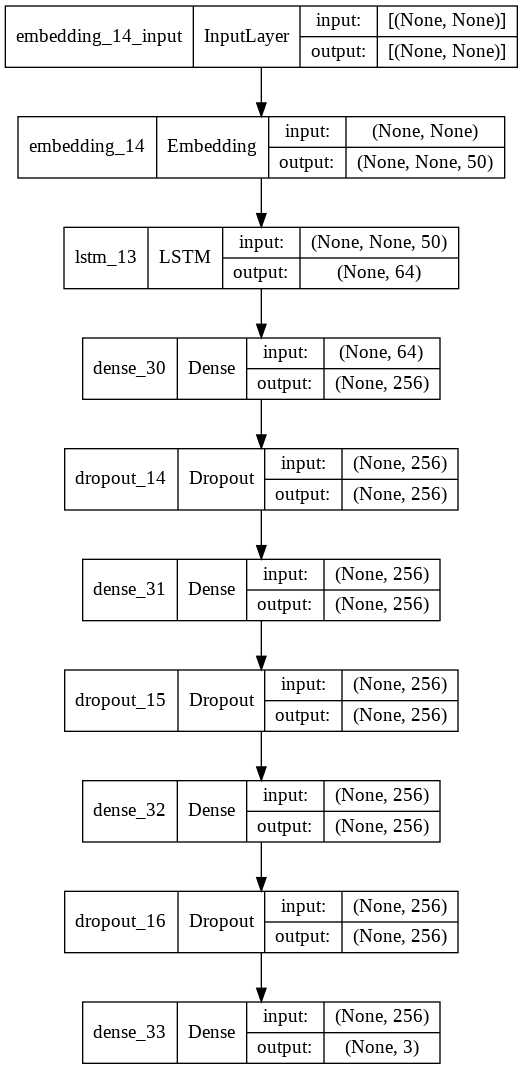

In [176]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model3, to_file='customer_sentiment_model3.png', show_shapes=True)
Image(filename='customer_sentiment_model3.png')

In [177]:
history3 = model3.fit(sequence_matrix, y_new_train,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1220/1220 [==============================] - 15s 10ms/step - loss: 0.5022 - accuracy: 0.8149 - val_loss: 0.4682 - val_accuracy: 0.8272
Epoch 2/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4602 - accuracy: 0.8275 - val_loss: 0.5810 - val_accuracy: 0.8271
Epoch 3/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4455 - accuracy: 0.8323 - val_loss: 0.5118 - val_accuracy: 0.8048
Epoch 4/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4384 - accuracy: 0.8349 - val_loss: 0.4377 - val_accuracy: 0.8285
Epoch 5/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4328 - accuracy: 0.8368 - val_loss: 0.4649 - val_accuracy: 0.8320
Epoch 6/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4262 - accuracy: 0.8381 - val_loss: 0.4351 - val_accuracy: 0.8333
Epoch 7/50
1220/1220 [==============================] - 12s 10ms/step - loss: 0.4218 - accuracy: 0.8408 - val_loss: 0.4350 -

In [178]:
history3_df = pd.DataFrame(history3.history)
history3_df.tail()

,loss,accuracy,val_loss,val_accuracy
7,0.416346,0.841373,0.478754,0.817609
8,0.412823,0.842405,0.472665,0.835115
9,0.408894,0.844981,0.456315,0.835499
10,0.407011,0.846801,0.460946,0.830168
11,0.404325,0.846762,0.442626,0.830732


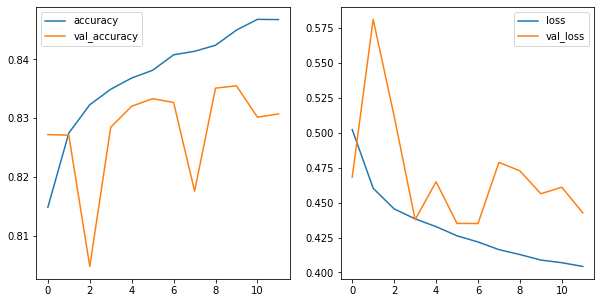

In [179]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3_df.accuracy, label='accuracy')
plt.plot(history3_df.val_accuracy, label='val_accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history3_df.loss, label='loss')
plt.plot(history3_df.val_loss, label='val_loss')
plt.legend()
plt.show()

In [180]:
# test
test_sequence = tok.texts_to_sequences(X_new_test)
test_sequence_matrix = sequence.pad_sequences(test_sequence, maxlen=max_len)

In [181]:
accr = model3.evaluate(test_sequence_matrix, y_new_test)
print('Test set\n -Loss: {:0.3f}\n -Accuracy: {:0.3f}'.format(accr[0], accr[1]))

2613/2613 [==============================] - 10s 4ms/step - loss: 0.4510 - accuracy: 0.8288
Test set
 -Loss: 0.451
 -Accuracy: 0.829


# Kết luận:
Chọn model 1 có Accuracy cao nhất và loss thấp nhất trong 3 model:
 - Loss: 0.385
 - Accuracy: 0.855